# Project - Day 1 - Practicing with Cygno data and NATS 🦢📡

## Introduction
The aim of the CYGNO project is to prove the capability of a high resolution gaseous TPC with sCMOS (scientific CMOS) optical readout for near future directional Dark Matter searches at low 1-10 GeV WIMP masses down to and beyond the Neutrino Floor. CYGNO consists of one cubic meter demonstrator to be installed at LNGS aiming to show the following performances and capabilities:
 
 * O(keV) energy threshold on nuclear recoil tracks;
 * 3d tracking reconstruction with head-tail determination;
 * 3d detector fiducialization;
 * Electron rejection power of $10^5$;
 * Complete background rejection thanks to the very good particle detection and identification;
 * Operate light target, such as He-based gas mixtures;
 * High sensitivity to 1-10 GeV WIMP mass region

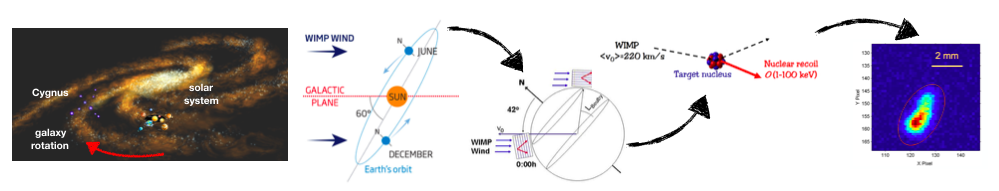


In this first exercise we will focus on the Data Acquisition (DAQ) system and on the preprocessing step.

### Data Acquisition and Data Flow

The Data Acquisition pipeline is simulated for you. 
The simulation-generated images are uploaded to an object storage and the link to download it will be broadcasted through NATS.
We will cover object storage tomorrow, for today you can think it as a Cloud Drive from which you can download data through an URL including an authorization token, named a *presigned URL*.

So, our application should obtain the presigned URL and use it to download the image via HTTPS.
Then we will introduce a preprocessing step preparing the picture for machine learning, and finally (tomorrow) we will upload it to our own object storage.

The final data flow we aim at is represented in the following figure.

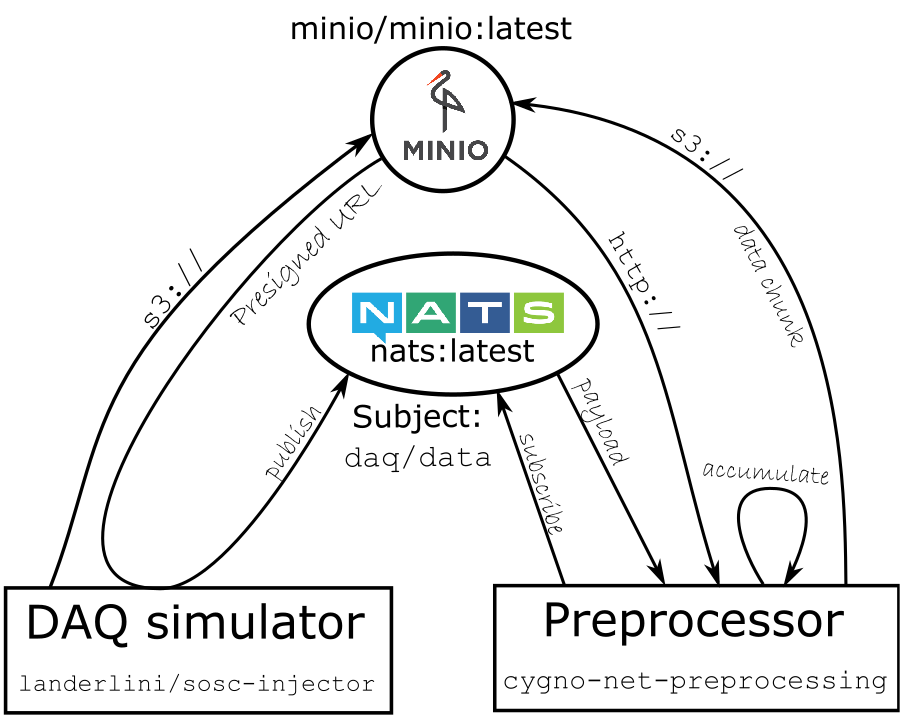

This conceptual procedure, while be rather simplified in the operations executed, is very common in real experiments. Instead of a preprocessing step they may feature a reconstruction or an online selection step, or a compression or whatever is worth to avoid storing the whole amount of acquired data for offline processing.

The implementation, instead, is very basic as we aim to expose to you the fundamental building blocks before discussing turnkey solutions (that we will do before the end of the school!)

Let's start with importing the standard Data Science libraries (`numpy`, `pyplot`) and `os` to access the local file system.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

## Exercise 1 - Obtain data URLs from DAQ via NATS

Then we will subscribe to the broadcast service to obtain the presigned URLs of the acquired data using NATS.

The NATS server and subject at which you will find the streamed data is 
```
NATS SERVER:  "nats://nats.injector:4222"
NATS SUBJECT: "daq/data"
```

For an example of subscribing to a NATS subject with the `pynats` package can be found in the [project's GitHub page](https://github.com/mcuadros/pynats). 

Your next cell should probably look like
```python
import pynats
NATS_SERVER = "nats://nats.injector:4222"
NATS_SUBJECT = "daq/data"

def callback(msg):
    """
    Callback function for NATS Client.
    It will be called whenever a message with the subscribed subject is received.
    """
    print (msg.payload)

with pynats.NATSClient(NATS_SERVER) as client:
    client.connect()
    # Your code to subscribe to the NATS subject goes here
    client.wait(count=3)

```

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)

In [ ]:
import pynats
NATS_SERVER = 'nats://nats.injector:4222'
NATS_SUBJECT = 'daq/data'

nats_payloads = []

def callback(msg):
    print('MSG: ', msg)
    nats_payloads.append(msg.payload)
    logging.debug('PAYLOAD: ', msg.payload)

with pynats.NATSClient(NATS_SERVER) as client:
    client.connect()
    print (f"Subscribing to {NATS_SERVER} for subject '{NATS_SUBJECT}'")
    client.subscribe(subject=NATS_SUBJECT, callback=callback)
    
    client.wait(count=3)

Great! Now it's time to do something of the message injected through NATS. 

The first thing we need is to digest the message and to extract the information it carries, notably:
 * the timestamp of the recorded interaction (the ***metadata***)
 * the acquired image of the interaction (the ***data***)

Now, the NATS `payload` is a raw byte stream, to make it a string we need to agree with the sender on an encoding. Most encoding are equal for the alphanumeric characters, but you might be unable to send nice emojis (and most importanly accented letters) if do not agree on an encoding before starting a communication. 

Maybe luckily, our NATS injector is not interested in submitting emojis 😢, so any encoding is ok, but still you need to choose one. 

Usually people pick `ascii` if they are sure special characters are not there, or `utf-8` if living in a standard Linux world, or `latin-1` if they need to support Windows.

Once you have a string, you can decode it using the `json` module of the Python Standard Libraries, to extract the url and timestamp fields.

The `unpack_payload` function defined here implements these steps for you.

The payoad obtained from NATS should include a JSON-formatted payload with the following keys:
 * The `url` we should use to download the image
 * The `time` representing the timestamp of the event at the time it was collected
 * The `filename` that you may want to use to store the file locally to maintain a unique identifier common to other participants.

To decode the payload you can reuse the following example code.

In [ ]:
import json

def unpack_payload (payload):
    """Unpack the message payload returning a tuple (timestamp, url)."""
    ## Convert the message data in a string, assuming utf-8 encoding
    payload_string = str(payload, 'utf-8')
    ## Convert the payload to a dictionary using the json module
    payload_dict = json.loads(payload_string)
    ## Obtain the url and the timestamp from the dictionary
    url = payload_dict['url']
    timestamp = payload_dict['time']

    ## Return the timestamp and the url
    return timestamp, url


example_payload = b'{"url": "https://some.url/file.png", "time": "2024-11-27 14:27:36.570564", "filename": "cygno-48c2a353fa54e2691da977dae9c9c460.jpg"}'
timestamp, url = unpack_payload(payload=example_payload)
print (f"Timestamp: {timestamp}\nURL: {url}")

## Exercise 2 - Download the image with a GET HTTP request ⌛



Now that you have clear how to use NATS to retrieve the URL of the image.

Conceptually, we should code the following operations:
 * perform a HTTPS request to retrieve the image from the remote server
   (we will use the [`requests`](https://requests.readthedocs.io/en/latest/) to the purpose)
 * convert the raw bytes we receive in the response into a file-like object
   (we will use [`io.BytesIO`](https://docs.python.org/3/library/io.html#binary-i-o) to create memory-resident file-like objects to avoid writing real files in our file-system)
 * convert the raw bytes we receive in the response into a Image object
   (we will use the [`pillow`](https://python-pillow.org/) package and its `Image` module)

The following block packages these three operations in the `download_image` function and show how to use it to download an INFN logo.

> **Note!** Since the HTTPS endpoint we are using for this exercise is not available to the general Internet we have a self-signed TLS certificate that triggers errors in HTTPS requests because it cannot be checked that the server was not compromised.
> Disabling certificate verification (`verify=False`) triggers a warning, that you can safely ignore only because this is a toy setup.

In [ ]:
import requests
requests.packages.urllib3.disable_warnings()
from PIL import Image
from io import BytesIO

def download_image(url):
    """Download an image via http and return the PIL.Image object"""
    
    ## Download the image via the presigned url
    response = requests.get(url, verify=False)
    ## Ensure the request was successful
    response.raise_for_status()
    ## Download the response content to a memory-located buffer
    buffer = BytesIO(response.content)
    ## Read the buffer as an image
    return Image.open(buffer)

download_image("https://home.infn.it/images/layout/INFN_logo_sito.png")

Pillow images can be easily converted in numpy arrays.

In [ ]:
# Retrieve the image as an Image object
pillow_image = download_image("https://home.infn.it/images/layout/INFN_logo_sito.png")
# Conert the image to a numpy array
numpy_image = np.array(pillow_image)
# Show the image
plt.imshow(numpy_image)
plt.show()

You should now plug all together in a new callback function to download the image from the object storage each time the address is broadcasted.

We will convert push the downloaded `Image` objects into `numpy` objects and then we append it to a global list.
We will download a batch of ten images and then stop.

Your solution should look like:
```python
import pynats
NATS_SERVER = "nats://nats.injector:4222"

list_of_numpy_images = []

def callback(msg):
    # your code here
    
with pynats.NATSClient(NATS_SERVER) as client:
    client.connect()
    # your subscription to subject here
    client.wait(count=10)
```

In [ ]:
list_of_numpy_images = []

def callback(msg):
    print("MSG: ", msg)
    _, url = unpack_payload(msg.payload)
    pil_image = download_image(url)
    list_of_numpy_images.append(np.array(pil_image))

with pynats.NATSClient(NATS_SERVER) as client:
    client.connect()
    print (f"Subscribing to {NATS_SERVER} for subject '{NATS_SUBJECT}'")
    client.subscribe(subject=NATS_SUBJECT, callback=callback)
    
    client.wait(count=10)

Finally, we can pack the images into a single numpy array and plot a few of them as 

```python
chunk = np.array(list_of_numpy_images)
print ("Chunk shape:", chunk.shape)
chunk = np.array(list_of_numpy_images)

plt.figure(figsize=(10, 4))
for i_plot, plot in enumerate(chunk, 1):
    plt.subplot(2, 5, i_plot)
    plt.imshow(plot, cmap='gray')
    
plt.tight_layout()
plt.show()
```

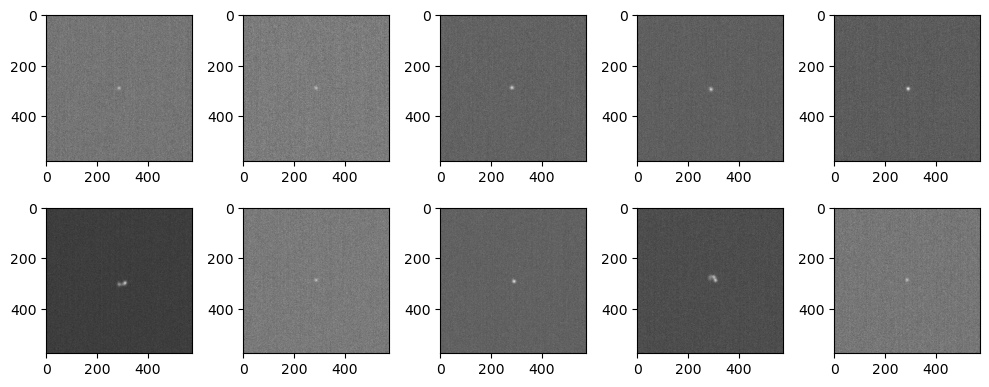

In [ ]:
chunk = np.array(list_of_numpy_images)
print ("Chunk shape:", chunk.shape)
chunk = np.array(list_of_numpy_images)

plt.figure(figsize=(10, 4))
for i_plot, plot in enumerate(chunk, 1):
    plt.subplot(2, 5, i_plot)
    plt.imshow(plot, cmap='gray')
    
plt.tight_layout()
plt.show()

# Preprocessing

To make sense of these images we must compare them with Simulation where we know the so-called *ground-truth*.

The ground-truth dataset we are using was obtained by simulating WIMP and electon recoils in the target vessel with Geant 4, and then acquiring the image.

Let's start by downloading the simulated datasets from an INFN repository and let's unzip it.

In [ ]:
!mkdir -p ${HOME}/data
!wget --no-check-certificate https://pandora.infn.it/public/269d22/dl/training_set.zip -O ${HOME}/training_set.zip
!cd ${HOME}; unzip -qn ${HOME}/training_set.zip 

We can use the glob module (part of the Python Standard Libraries) to list the files we have downloaded and the directory structure.

Here, we limit ourselves to 10 files, but you can list all of them 😋

In [ ]:
from glob import glob
input_files = glob ("/home/jovyan/data/export/train/*/*/*.png")
input_files[:10]

### Exercise 3 - Obtain the ground-truth from the file path -⌛
Let's define two functions to determine whether the considered file was generated as a nuclear (NR) or an electronic (ER) recoil, and to determine the simulated energy from the path.

The first one is given...

In [ ]:
def get_recoil_type(filename):
    """
    Return the strings "nuclear" or "electronic" if the file is 
    located in a subdir of "NR" or "ER", respectively.
    Return None otherwise.
    """
    if "NR" in filename.split("/"):
        return 'nuclear'
    if "ER" in filename.split("/"):
        return "electronic"
    return None

## Example
get_recoil_type(input_files[0])

The second is up to you.
> **💡 Hint.** You may want to start with:
> ```python
> def get_energy_keV(filename):
>   """Return the energy in keV as a float as obtained parsing filename"""
>   #... your code here ...
> ```
> 
> Also, check:
>  * the [`str.split`](https://docs.python.org/3.11/library/stdtypes.html#str.split) method
>  * usage of the `in` operator for *membership testing* (e.g. on [tutorialspoint.com](https://www.tutorialspoint.com/python/membership_operators_example.htm))
>  * string slicing (e.g. on [realpython.com](https://realpython.com/python-strings/#string-slicing))

In [ ]:
def get_energy_keV(filename):
    kev = float(filename.split("/")[-2].split('_')[0])
    return kev

get_energy_keV(input_files[0])

## Exercise 4 - Load and draw a datafile using pillow -⌛

We move now to the Image manipulation part of the exercise. This is a necessary step to develop Machine Learning techniques on the image.
Manipulating images with numpy has been considered a "prerequirement" for the SOSC, but you may want to review some of the most common operations to be performed in the notebook ["Handling Image Data in Python"](./01-ImageDataInPython.ipynb).

Using the `Image` module from pillow (`from PIL import Image`, and then `Image.open(<path>)` ) you can load and display an image.

You should expect something on the line of the following figure:

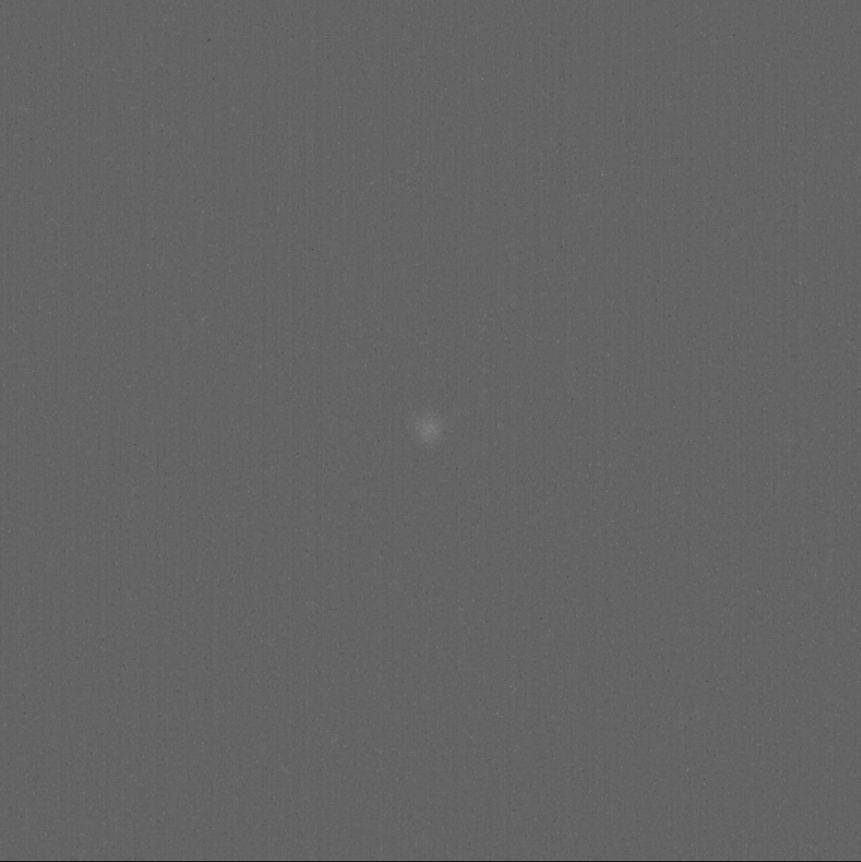

In [ ]:
Image.open(input_files[0])

## Exercise 4a - Define a function to compute the histogram of a single figure - ⌛⌛
The image we have plotted above, shows clearly that the contrast is not optimal.
However, this might be due to the fact that the contrast of that single image is indeed suboptimal, or rather that the whole sample is shrinked in a subset of the 256 possible values.

To discover in which of these different situations we are in, let's build a histogram of the pixel values of the whole dataset (and not of a single image).

We start gently defining a function that takes as an input the filename and provides as an output the counts of the pixel values in the range 0 to 255.

> 💡**Hint.** You may want to use the following numpy functions (click for the docs):
> * [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) creates an array of equidistant values in a specified range
> * [`np.histogram`](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) computes the number of entries in (possibly user-defined) bins
> * [`np.array.flatten`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) unroll a multidimensional array to get a 1D array with the same (now unstructured) content
>
> Your solution may look like
> ```python
> def compute_pixel_hist(filename):
>    """
>    Compute and return the histograms of the pixel values of filename, 
>    one bin per pixel value in range 0-255.
>    """
>    np_image = np.array(<your code here>)
>    boundaries = np.linspace(-0.5, 255.5, 257)
>    contents, _ = np.histogram(np_image.flatten(), bins=boundaries)
>    ...
> ```

In [ ]:
def compute_pixel_hist(filename, plot=False):
    """
    Compute and return the histograms of the pixel values of filename, 
    one bin per pixel value in range 0-255.
    """
    np_image = np.array(Image.open(filename))
    boundaries = np.linspace(0, 255, 256)
    contents, _ = np.histogram(np_image.flatten(), bins=boundaries)

    if plot:
        plt.hist(np_image)
        logging.debug("computed:\n  %s\n  %s", contents, boundaries)  
        plt.hist(boundaries[:-1], boundaries, weights=contents) 
    
    return boundaries, contents

compute_pixel_hist(input_files[0], plot=True)

## Exercise 4b - Obtain and draw the histogram for the whole dataset - ⌛⌛
Loop on all the file names obtained from the downloaded archive and, for each of them, compute the histogram.
Then sum all of the histograms contents together to obtain the histogram of the whole image dataset.
Draw it.

> 💡**Hint.** You may want to use [`plt.stairs`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.stairs.html) to draw this histogram instead of [`np.hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html). Indeed, [`np.hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) "computes and displays" the histogram, while in this case, you have computed the histogram already and you just need to show it.

In [ ]:
cs = np.zeros(255)
bs = None
for f in input_files:
    b, c = compute_pixel_hist(f)
    cs += c
    bs = b


plt.hist(bs[:-1], bs, weights=cs) 

## Exercise 5 - Windowing and conversion to float - ⌛
Define a function taking as an input the numpy-converted image and two values for the minimal and maxmal brightness and returning a rescaled value of each pixel ito fit that range into the interval [0, 1].

Obtain minima and maxima brightness from the histogram drawn in Exercise 3.

Try to visualize the image obtained from this preprocessing.

> 💡**Hint.** A skeleton of the solution might be:
> ```python
> def windowing(np_image, x_min, x_max):
>   """Maps the pixel values from the interval [x_min, x_max] to [0, 1]"""
>   ... your code here ...
>
> plt.imshow(windowing(np_image, ... your values here ...), cmap='gray')
> ```

In [ ]:
def windowing(np_image, x_min, x_max):
    filtered_img = (np_image - x_min)/(x_max-x_min)
    return np.clip(filtered_img, 0, 1)

plt.imshow(windowing(np.array(Image.open(input_files[0])), 98, 105), cmap='gray')

## Exercise 6 - Define a function cropping the inner part of the image - ⌛⌛
Define a function `crop_center` taking as input a numpy-image and `half_win` and return a squared numpy-image of side `2*half_win` centered on the center of the input image.

In other words, if the center of the input image is `(x0, y0)` you should return a portion of the original figure identified by the bounding box 
`(x0 - half_win, y0 - half_win), (x0 + half_win, y0 + half_win)`.

> A skeleton of the solution might be:
> ```python
> def crop_center(np_image, half_win=64):
>   """Crop a numpy-represented image around its center, the resulting image will be a square of side 2*half_win"""
>   ... your code here ...
>
> plt.imshow(crop_center(np_image), cmap='gray')
> ```

In [ ]:
def crop_center(np_image, half_win=64):
    logging.debug("IM SHAPE: %s", np_image.shape)
    x0 = np_image.shape[0] // 2
    y0 = np_image.shape[1] // 2
    
    logging.debug(x0,y0)
    logging.debug(np_image)
    
    cropped_image = np_image[x0 - half_win:x0+half_win, y0-half_win:y0+half_win]
    logging.debug("CROPPED IMG: %s", cropped_image)

    return cropped_image

plt.imshow(crop_center(np.array(Image.open(input_files[0]))), cmap='gray')

## Exercise 7 - Define a function cropping the inner part of the image - ⌛⌛⌛
Apply the preprocessing steps (windowing and crop) to five images for nuclear recoil and five images for electronic recoil and plot them.

<BIG>🔮</BIG> You may expect a figure similar to the following one, where the nuclear recoil is represented in blue and the electronic recoil in pink.
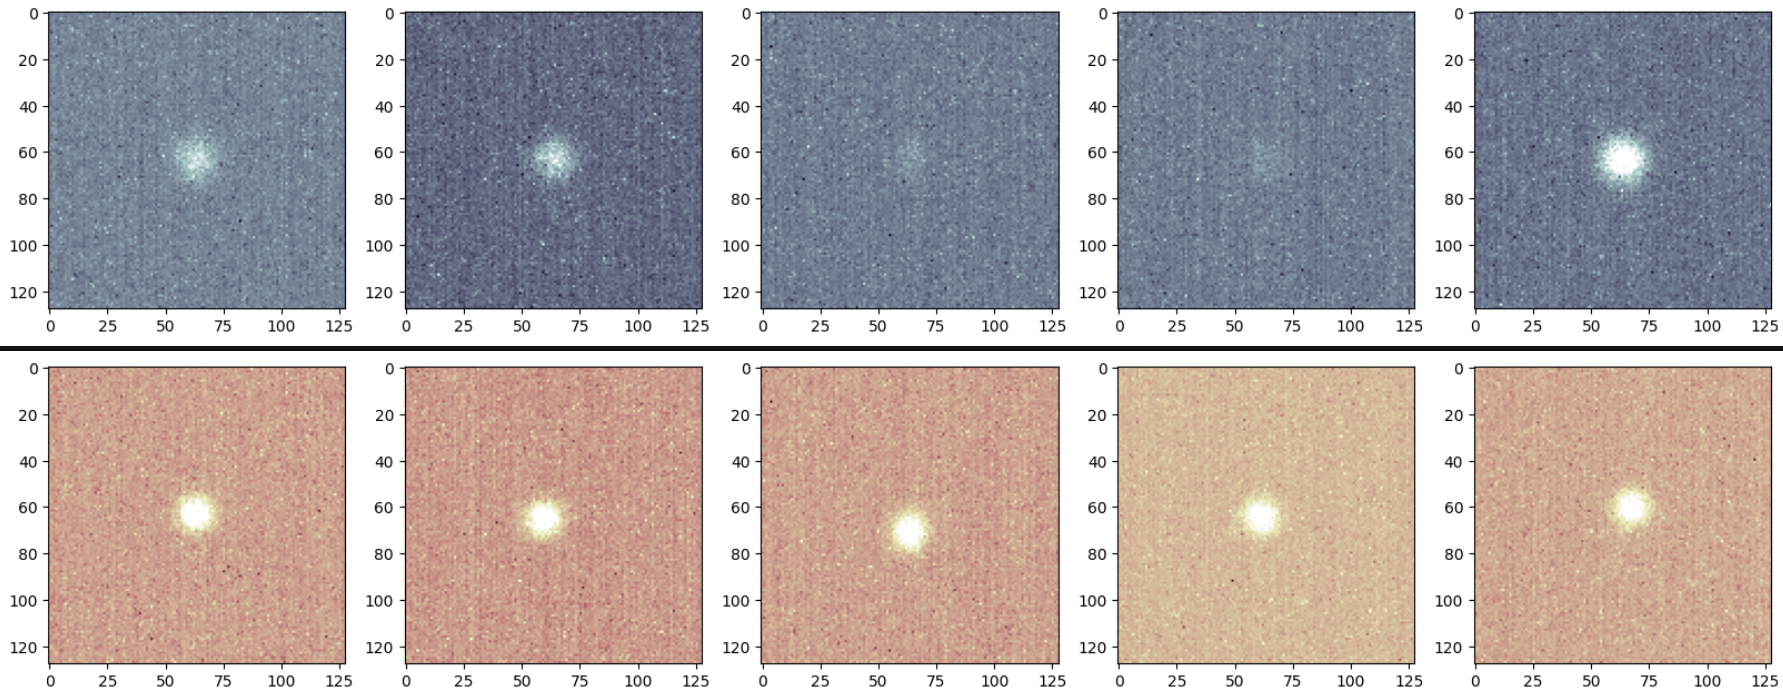



In [ ]:
nuclear_in = input_files[:5]
electronic_in = input_files[-6:-1]

# nuclear
fig, axs = plt.subplots(1, 5, figsize=(10,9))
for i, nuc in enumerate(nuclear_in):
    proc_img = crop_center(windowing(np.array(Image.open(nuc)), 80, 110))
    axs[i].imshow(proc_img, cmap='Blues_r')
fig.tight_layout()
plt.show()

# electric
fig, axs = plt.subplots(1, 5, figsize=(10,9))
for i, elec in enumerate(electronic_in):
    proc_img = crop_center(windowing(np.array(Image.open(elec)), 80, 110))
    axs[i].imshow(proc_img, cmap='pink')
fig.tight_layout()
plt.show()

## Exercise 8. Plug the preprocessing step in your DAQ NATS callback.

Let's conclude this notebook by combining everything together, plugging the code developed in the second part of the notebook within the NATS callback in order to apply the preprocessing step in real time to each new incoming image.

```python
import pynats
NATS_SERVER = "nats://nats.injector:4222"

list_of_numpy_images = []

def callback(msg):
    # your preprocessing code here
    
with pynats.NATSClient(NATS_SERVER) as client:
    client.connect()
    # your subscription to subject here
    client.wait(count=10)
```

In [ ]:
NATS_SERVER = "nats://nats.injector:4222"

list_of_numpy_images = []

def callback(msg):
    # your preprocessing code here
    print("MSG: ", msg)
    _, url = unpack_payload(msg.payload)
    pil_image = download_image(url)
    np_image = np.array(pil_image)
    proc_image = crop_center(windowing(np_image, 80, 110))
    
    plt.imshow(proc_image, cmap='gray')
    plt.show()
    
    list_of_numpy_images.append(proc_image)
    
with pynats.NATSClient(NATS_SERVER) as client:
    client.connect()
    # your subscription to subject here
    print (f"Subscribing to {NATS_SERVER} for subject '{NATS_SUBJECT}'")
    client.subscribe(subject=NATS_SUBJECT, callback=callback)

    client.wait(count=10)

# Conclusion

In this notebook we learned how to obtain images from the DAQ processing messages from NATS, retrieving a presigned URL and using it to download the image with an HTTPS GET request.

Then we developed the preprocessing step based on simulation and finally we put all together to embed the preprocessing pipeline in DAQ part.